<a href="https://colab.research.google.com/github/Pasindu457825/Deep-Learning-Lab_07_Part_02/blob/main/Gridworld_DQN_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# if old Gym is fine:
!pip install gym==0.26.2 box2d-py

# OR with Gymnasium (newer API)
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827727 sha256=b5cdaebbe91426b46d6d6a87a5fe62acb363e00c8a0a14f51aaf85d61ea05d3e
  Stored in directory: /root/.cache/pip/wheels/95/51/6c/9bb05ebbe7c5cb8171dfaa3611f32622ca4658d53f31c79077
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Successfully built gym
Failed to build box2d-py
ERROR: ERROR: Failed to build installable whe

In [6]:
!pip uninstall -y box2d-py Box2D


In [7]:
!pip install -U box2d==2.3.10 swig==4.* pygame
# if gymnasium isn't installed yet (you already have it, so you can skip this)
# !pip install gymnasium[box2d]


  Using cached swig-4.3.1.post0-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (3.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 33.7 MB/s eta 0:00:00
Using cached swig-4.3.1.post0-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.9 MB)


In [8]:
import Box2D
from Box2D import b2World
print("Box2D OK")


Box2D OK


In [5]:
import numpy as np, random
from collections import deque
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
# Example ONLY if you need a placeholder
# Replace this with *your* Gridworld class
class GridworldEnv:
    def __init__(self, rows=5, cols=5):
        self.rows, self.cols = rows, cols
        self.n_states = rows*cols
        self.n_actions = 4  # up,right,down,left
        self.s = 0
        self.terminal = {24}
    def to_id(self, r,c): return r*self.cols + c
    def reset(self):
        self.s = 0
        return self.s
    def step(self, a):
        # TODO: replace with your real dynamics
        self.s = min(self.s+1, self.n_states-1)
        r = 1.0 if self.s in self.terminal else -0.01
        done = self.s in self.terminal
        return self.s, r, done, {}
env = GridworldEnv()


In [10]:
USE_ONE_HOT = True
state_dim = env.n_states
n_actions = env.n_actions

def to_tensor_state(s):
    x = np.zeros(state_dim, dtype=np.float32)
    x[int(s)] = 1.0
    return torch.from_numpy(x).unsqueeze(0).to(DEVICE)

class DQN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, out_dim)
        )
    def forward(self, x): return self.net(x)

def act(qnet, state, epsilon):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    with torch.no_grad():
        q = qnet(to_tensor_state(state))
        return int(q.argmax(dim=1).item())


In [11]:
def train_dqn_fixed_eps(epsilon, episodes=500, gamma=0.99, lr=1e-3):
    qnet = DQN(state_dim, n_actions).to(DEVICE)
    opt = optim.Adam(qnet.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    ep_returns = []

    for ep in range(episodes):
        s = env.reset()
        done, ep_ret = False, 0.0
        while not done:
            a = act(qnet, s, epsilon)
            s2, r, done, _ = env.step(a)

            with torch.no_grad():
                target = torch.tensor([r], dtype=torch.float32, device=DEVICE)
                if not done:
                    q_next = qnet(to_tensor_state(s2)).max(1).values
                    target = target + gamma * q_next

            q_pred = qnet(to_tensor_state(s))[0, a]
            loss = loss_fn(q_pred, target)
            opt.zero_grad(); loss.backward(); opt.step()

            s, ep_ret = s2, ep_ret + r
        ep_returns.append(ep_ret)
    return ep_returns


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


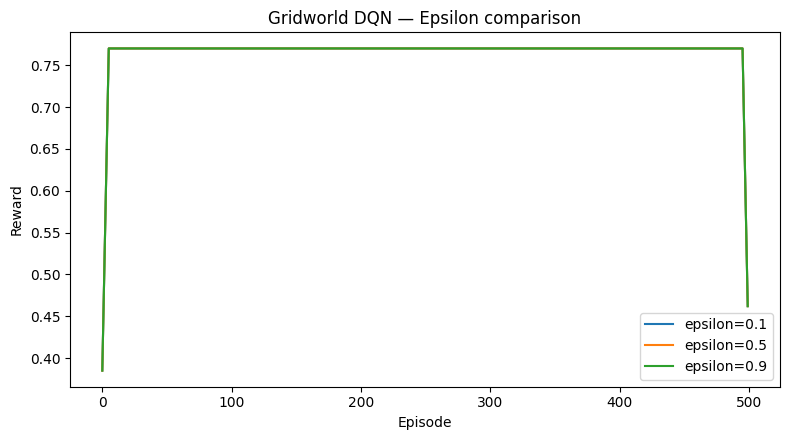

epsilon=0.1: last-50 avg = 0.770
epsilon=0.5: last-50 avg = 0.770
epsilon=0.9: last-50 avg = 0.770


In [12]:
def sma(x, k=10):
    if len(x)<k: return x
    w = np.ones(k)/k
    return np.convolve(x, w, mode='same')

eps_list = [0.1, 0.5, 0.9]
curves = {eps: train_dqn_fixed_eps(eps) for eps in eps_list}

plt.figure(figsize=(8,4.5))
for eps, y in curves.items():
    plt.plot(sma(y,10), label=f"epsilon={eps}")
plt.xlabel("Episode"); plt.ylabel("Reward")
plt.title("Gridworld DQN — Epsilon comparison")
plt.legend(); plt.tight_layout(); plt.show()

for eps, y in curves.items():
    print(f"epsilon={eps}: last-50 avg = {np.mean(y[-50:]):.3f}")
